In [12]:
import matplotlib.pyplot as plt
################################################################################
# IntroToCSE
# IVPlib_rev4
#

"""
This Python library is useful in solving Initial Value Problems (IVP).

It implements an IVP base class which defines an IVP in the form:
    
    du/dt = f(u,t,p)   for u(tI) = uI

In which the problem would be solved from t=tI to tF and p are a set of 
parameters

Notes: This rev of IVPlib includes:
    * solve: generic IVP solver which calls a function that takes a single step
    * step_FE: takes a single step of Forward Euler method
    * step_RK2_ME: takes a single step of the RK2 modified Euler method
    * virtual evalf (to be defined in a subclass)
    * getters
    * __len__
"""

import copy 

class IVP():
    def __init__(self, uI, tI, tF, p={}):
        """
        Args:
            uI (float list): initial condition of state.
            tI (float): initial time.
            tF (float): final time.
            p (dictionary): set of fixed parameters.
        """
        
        self._uI = uI[:]
        self._tI = tI
        self._tF = tF
        self._p  = copy.deepcopy(p)

############ (other) dunder methods ############

    def __len__(self):
        """
        len is defined as number of states (in _uI)
        """
        return len(self._uI)
        
############ virtual methods for use outside of class ############
 
    def evalf(self,u,t):
        """
        Args:
            u (float list): current solution.
            t (float): current time.

        Returns:
            float list: f(u,t).
        """
        raise NotImplementedError("evalf is not implemented for this object")

############ getter methods ############

    def get_tI(self):
        """
        Returns:
            float: initial time.
        """
        return self._tI

    def get_tF(self):
        """
        Returns:
            float: final time.
        """
        return self._tF

    def get_uI(self):
        """
        Returns:
            float list: initial state
        """
        return self._uI[:]

    def get_p(self, name):
        """
        Arg:
            name (key): a key which should be in the object's parameter
            dictionary

        Returns:
            value of parameter key given by name
        """
        return self._p[name]

################################################################################
## Functions to numerically integrate an IVP
################################################################################

def step_FE(thisIVP,dt,un,tn):
    """
    Takes a single timestep of the Forward Euler method (FE) to
    (approximately) integrate the state from u(tn) to u(tn+dt)

    Args:
        thisIVP (IVP object): object describing IVP being solved.
        dt (float): time increment.
        un (float list): current state, i.e. u(tn).
        tn (float): current time.

    Returns:
        float list: next state, i.e. u(tn+dt).

    """

    fn = thisIVP.evalf(un,tn)
    un1 = []
    for i in range(len(un)):
        un1.append(un[i] + dt*fn[i])

    return un1


def step_RK2_ME(thisIVP,dt,un,tn):
    """
    Takes a single timestep of the 2nd order Runge-Kutta method knowns as
    the modified Euler method to (approximately) integrate the state from 
    u(tn) to u(tn+dt)

    Args:
        thisIVP (IVP object): object describing IVP being solved.
        dt (float): time increment.
        un (float list): current state, i.e. u(tn).
        tn (float): current time.


    Returns:
        float list: next state, i.e. u(tn+dt).

    """

    # compute RHS for the a vector
    ta = tn
    ua = un
    fa = thisIVP.evalf(ua, ta)
    # compute the a vector
    a = []
    for i in range(len(un)):
        a.append(dt*fa[i])

    # compute RHS for the b vector
    tb = tn + 0.5*dt
    ub = []
    for i in range(len(un)):
        ub.append(un[i] + 0.5*a[i])
    fb = thisIVP.evalf(ub, tb)
    # compute the b vector
    b = []
    for i in range(len(un)):
        b.append(dt*fb[i])

    # compute the next step
    un1 = []
    for i in range(len(un)):
        un1.append(un[i] + b[i])

    return un1


def solve(thisIVP, dt, method):
    """
    Solves an IVP using a timestep dt and method. Integrate from t=tI until u(tn) is
    determined for which tn >= tF.

    Args:
        thisIVP (IVP object): object describing IVP being solved.
        dt (float): time increment.
        method (function): numerical integration method to use.

    Returns:
        t (float list): time values at which u(t) is approximated. The nth item in
            the list is the time of the nth step, tn = t[n].
        u (list of float lists): The values of the states at each step.  The nth
            item in the list is the values of the states at tn.  i.e. u(tn) = u[n]
            where u[n] is a float list.  So, if there are three equations being integrated, then
            u[n][0], u[n][1], and u[n][2] are the values of the three states at time t=t[n]

    IMPORTANT: The first element in the returned t and u lists will be the initial values
    of t and u.  Thus:
        * t[0] will be a float which is equal to thisIVP.get_tI()
        * u[0] will be a float list which is equal to thusIVP.get_uI()
    """

    # Gets initial condition, tI and tF
    tI = thisIVP.get_tI()
    tF= thisIVP.get_tF()
    uI = thisIVP.get_uI()
    
    # Create t and u lists, and set initial element
    t = [tI]
    u = [uI]

    # Loop from t=tI to t>=tF
    tn = tI
    un = uI
    while (tn<tF):
        un1 = method(thisIVP,dt,un,tn)
        u.append(un1)
        un = un1
        tn += dt
        t.append(tn)

    return t, u

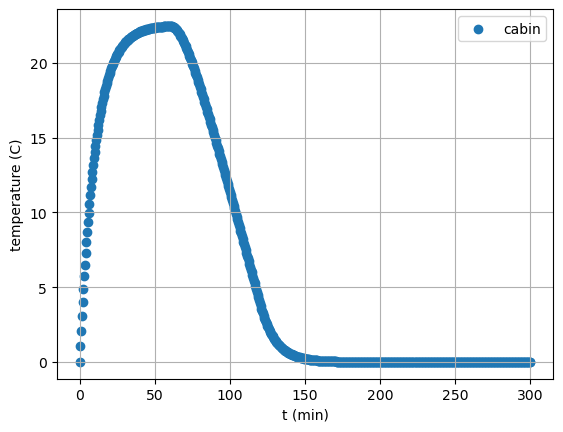

In [13]:
class CabinIVP(IVP):
    def evalf(self, u, t):
        """        
        Args:
            u (float list): current temperature of cabin.
            t (float): current time
    
        Returns:
            f (float list): returns du/dt
        """

        m0cc = self.get_p('m0')*self.get_p('cc')
        hA_left  = self.get_p('h_left')  * self.get_p('A_left')
        hA_right = self.get_p('h_right') * self.get_p('A_right')
        hA_back  = self.get_p('h_back')  * self.get_p('A_back')
        hA_front = self.get_p('h_front') * self.get_p('A_front')
        hA_top   = self.get_p('h_top')   * self.get_p('A_top')
        hA_bot   = self.get_p('h_bot')   * self.get_p('A_bot')
        
        u_out    = self.get_p('u_out')
        u_ground = self.get_p('u_ground')
        
        Q_stove  = self.get_p('Q_stove')

        A = -(hA_left + hA_right + hA_back + hA_front + hA_top + hA_bot)/m0cc
        
        Q_out    = (hA_left + hA_right + hA_back + hA_front + hA_top)*u_out(t)
        Q_ground = hA_bot*u_ground(t)

        b = (Q_out + Q_ground + Q_stove(t))/m0cc
        
        f = A*u[0] + b

        return [f]

def u_ground(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            u_ground (float): ground temperature at time t in deg C
    """
    return 0.0

def u_out(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            u_out (float): outside temperature at time t in deg C
    """
    return 0.0

def Q_stove(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            Q_stove (float): heat generated by stove at time t in Watts
    """
    
    tm = t/60. # time in min from secs
    if (tm<60.):
        Qdot = 5.0e3
    elif (tm < 120.):
        Qdot = 5.0e3*(120.-tm)/60.
    else:
        Qdot = 0.
        
    return Qdot


A_bt     = 50. # area of bottom, top (m^2)
A_lrfb   = 25. # area of left, right, front, back (m^2)
h_ground = 0.04 # ground heat transfer coefficient (W/(m^2 C))
h_roof   = 0.4 # roof heat transfer coefficient (W/(m^2 C))
h_ext    = 2.0 # exterior walls heat transfer coefficient (W/(m^2 C))
m0       = 200. # mass of cabin air
cc       = 700.0 # J / (kg C)
        
u0I   = 0.0 # Initial temperature of cabin (C)
tFmin = 300.0 # final time to simulate to (min)
dtmin = 5e-1 # time increment to give solutions at (min)

# Convert times to seconds
tF = tFmin*60
dt = dtmin*60

# Initialize CabinIVP object
p = {}
p['A_left']  = A_lrfb
p['A_right'] = A_lrfb
p['A_front'] = A_lrfb
p['A_back']  = A_lrfb
p['A_bot']   = A_bt
p['A_top']   = A_bt

p['h_left']  = h_ext
p['h_right'] = h_ext
p['h_front'] = h_ext
p['h_back']  = h_ext
p['h_bot']   = h_ground
p['h_top']   = h_roof

p['m0']      = m0
p['cc']      = cc

p['u_out']    = u_out
p['u_ground'] = u_ground
p['Q_stove']  = Q_stove

cabinIVP = CabinIVP([u0I], 0.0, tF, p)

# Solve cabin IVP
t, v = solve(cabinIVP, dt, step_FE)

# Extract cabin temperature from v and scale time to minutes
u  = []
for n in range(len(t)):
    t[n] = t[n]/60.0 # convert to minutes
    u.append(v[n][0])

# Plot   
fig, ax = plt.subplots()
ax.scatter(t,u,marker='o',label='cabin')
ax.set_xlabel('t (min)')
ax.set_ylabel('temperature (C)')
ax.grid(True)
ax.legend()


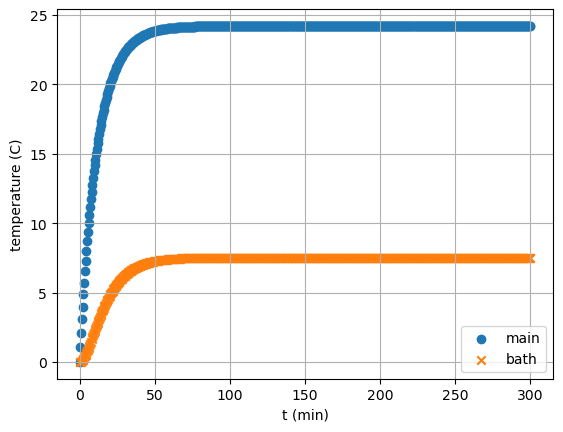

In [14]:
class Cabin2IVP(IVP):
    def evalf(self, u, t):
        """        
        Args:
            u (float list): current temperature of cabin.
            t (float): current time
    
        Returns:
            f (float list): returns du/dt
        """

        m0cc = self.get_p('m0')*self.get_p('cc')
        m1cc = self.get_p('m1')*self.get_p('cc')

        hA_01    = self.get_p('h_01')   * self.get_p('A_01')

        hA_0r    = self.get_p('h_0r')   * self.get_p('A_0r')
        hA_0b    = self.get_p('h_0b')   * self.get_p('A_0b')
        hA_0f    = self.get_p('h_0f')   * self.get_p('A_0f')
        hA_0top  = self.get_p('h_0top') * self.get_p('A_0top')
        hA_0bot  = self.get_p('h_0bot') * self.get_p('A_0bot')

        hA_1l    = self.get_p('h_1l')   * self.get_p('A_1l')
        hA_1b    = self.get_p('h_1b')   * self.get_p('A_1b')
        hA_1f    = self.get_p('h_1f')   * self.get_p('A_1f')
        hA_1top  = self.get_p('h_1top') * self.get_p('A_1top')
        hA_1bot  = self.get_p('h_1bot') * self.get_p('A_1bot')
        
        u_out    = self.get_p('u_out')
        u_ground = self.get_p('u_ground')
        
        Q0_stove  = self.get_p('Q_stove')

        A00 = -(hA_01 + hA_0r + hA_0b + hA_0f + hA_0top + hA_0bot)/m0cc
        A01 = hA_01/m0cc
        
        A10 = hA_01/m1cc
        A11 = -(hA_01 + hA_1l + hA_1b + hA_1f + hA_1top + hA_1bot)/m1cc
        
        Q0_out    = (hA_0r + hA_0b + hA_0f + hA_0top)*u_out(t)
        Q0_ground = hA_0bot*u_ground(t)
        b0 = (Q0_out + Q0_ground + Q0_stove(t))/m0cc
        
        Q1_out    = (hA_1l + hA_1b + hA_1f + hA_1top)*u_out(t)
        Q1_ground = hA_1bot*u_ground(t)
        b1 = (Q1_out + Q1_ground)/m1cc
        
        f0 = A00*u[0] + A01*u[1] + b0
        f1 = A10*u[0] + A11*u[1] + b1

        return [f0, f1]

def u_ground(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            u_ground (float): ground temperature at time t in deg C
    """
    return 0.0

def u_out(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            u_out (float): outside temperature at time t in deg C
    """
    return 0.0

def Q_stove(t):
    """
        Args:
            t (float): current time in seconds
    
        Returns:
            Q_stove (float): heat generated by stove at time t in Watts
    """
    return 5.0e3


A_0r     = 25.  # room0 area of right (m^2)
A_0fb    = 25.  # room0 area of front, back (m^2)
A_0bt    = 50.  # room0 area of bottom, top (m^2)
A_01     = 25.  # area of shared wall between room0 and room1 (m^2)
A_1l     = 25.  # room1 area of left (m^2)
A_1fb    = 12.5 # room1 area of front, back (m^2)
A_1bt    = 25.  # room1 area of bottom, top (m^2)
h_ground = 0.04 # ground heat transfer coefficient (W/(m^2 C))
h_roof   = 0.4 # roof heat transfer coefficient (W/(m^2 C))
h_int    = 2.0 # interior walls heat transfer coefficient (W/(m^2 C))
h_ext    = 2.0 # exterior walls heat transfer coefficient (W/(m^2 C))
m0       = 200. # mass of air in main room
m1       = 100. # mass of air in bath room
cc       = 700.0 # J / (kg C)
        
u0I   = [0.0, 0.0] # Initial temperature of cabin (C)
tFmin = 300.0 # final time to simulate to (min)
dtmin = 5e-1 # time increment to give solutions at (min)

# Convert times to seconds
tF = tFmin*60
dt = dtmin*60

# Initialize CabinIVP object
p = {}
p['A_0r']     = A_0r
p['A_0f']     = A_0fb
p['A_0b']     = A_0fb
p['A_0bot']   = A_0bt
p['A_0top']   = A_0bt

p['A_01']     = A_01

p['A_1l']     = A_1l
p['A_1f']     = A_1fb
p['A_1b']     = A_1fb
p['A_1bot']   = A_1bt
p['A_1top']   = A_1bt

p['h_0r']   = h_ext
p['h_0f']   = h_ext
p['h_0b']   = h_ext
p['h_0bot'] = h_ground
p['h_0top'] = h_roof

p['h_01']   = h_int

p['h_1l']   = h_ext
p['h_1f']   = h_ext
p['h_1b']   = h_ext
p['h_1bot'] = h_ground
p['h_1top'] = h_roof

p['m0'] = m0
p['m1'] = m1
p['cc'] = cc

p['u_out']    = u_out
p['u_ground'] = u_ground
p['Q_stove']  = Q_stove

cabin2IVP = Cabin2IVP(u0I, 0.0, tF, p)

# Solve cabin IVP
t, v = solve(cabin2IVP, dt, step_FE)

# Extract cabin and bathroom temperature from v and scale time to minutes
u0 = []
u1 = []
for n in range(len(t)):
    t[n] = t[n]/60.0 # convert to minutes
    u0.append(v[n][0])
    u1.append(v[n][1])

# Plot   
fig, ax = plt.subplots()
ax.scatter(t,u0,marker='o',label='main')
ax.scatter(t,u1,marker='x',label='bath')
ax.set_xlabel('t (min)')
ax.set_ylabel('temperature (C)')
ax.grid(True)
ax.legend()